In [7]:
# To extract data from .h5 files and put it into the arrays we need to make the following plots:
# rate vs time, temperature vs time, rate vs temperature
# The other slow control parameters (humidity, pressure and magnetic field) are also extracted.

# This notebook ensures the T3222 dataset does not start at t = 0, but takes into account the time between
# this dataset and the T2232 dataset in order to combine this dataset with the T2232 dataset and to correctly
# correct for change in slope due to radioactive decay.

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
import os
from glob import glob
import numpy as np
import scipy as scipy
from scipy import stats 
import scipy.optimize as optimize
from scipy.optimize import curve_fit

matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

In [2]:
# Read in data sets with pandas
store0425 = pd.HDFStore('ANA_mx_n_20160425_0752.h5')
store0426 = pd.HDFStore('ANA_mx_n_20160426_0736.h5')
store0428 = pd.HDFStore('ANA_mx_n_20160428_0755.h5')
store0430 = pd.HDFStore('ANA_mx_n_20160430_0840.h5')
store0502 = pd.HDFStore('ANA_mx_n_20160502_0752.h5')
store0504 = pd.HDFStore('ANA_mx_n_20160504_0846.h5')
store0506 = pd.HDFStore('ANA_mx_n_20160506_1521.h5')
store0509 = pd.HDFStore('ANA_mx_n_20160509_0805.h5')

In [3]:
# From analysis/monitor/fitspectrum.C: the energies corresponding to the photopeaks 

fit_values = {}

for i in range(8):
    fit_values[i] = {}

fit_values[0][0] = ('1460 keV','BG')
fit_values[1][0] = ('1460 keV','BG')

fit_values[2][0] = ('511 keV','Ti')
fit_values[3][0] = ('511 keV','Ti')
fit_values[2][1] = ('1157 keV','Ti')
fit_values[3][1] = ('1157 keV','Ti')
fit_values[2][2] = ('511.+1157 keV','Ti')
fit_values[3][2] = ('511.+1157 keV','Ti')


fit_values[4][0] = ('1173 keV','Co')
fit_values[5][0] = ('1173 keV','Co')
fit_values[4][1] = ('1332 keV','Co')
fit_values[5][1] = ('1332 keV','Co')
fit_values[4][2] = ('1332 + 1173 keV','Co')
fit_values[5][2] = ('1332 + 1173 keV','Co')

fit_values[6][0] = ('662 keV','Cs')
fit_values[7][0] = ('662 keV','Cs')

In [4]:
# Definition of needed functions:

# beautifull recursive defaultdict so that automatically all calls that do not excist return a new empty dict
from collections import defaultdict
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)

# Exponential to fit to find A0
def exp(x, A_0): # A_0=activity at t=0 in Bq, and half life time in seconds 
    return A_0*np.exp(-(x*60*60.)*np.log(2)/(half_life_time))

# Function to fit a function to data
def fit_signal(signal, guess, x):
    popt, pcov = curve_fit(exp, x, signal, guess)
    perr = np.sqrt(np.diag(pcov))
    A0 = popt[0]
    errA0 = perr[0]
    Fitted_exp_decay = exp(x, *popt)
    print("Half life time : %s yr" %(half_life_time/(365.25*24*60*60)))
    print("A0 : %s +- %s Bq" %(A0, errA0))
    return Fitted_exp_decay, A0, errA0

# Define residual rate:
def residual(x, exponent_and_modulation_and_noise, fit, plot_function = True):
    residual = (exponent_and_modulation_and_noise) - fit
    return residual

# Fit a gauss to residual histogram
def gauss(x,*p):
    A_g,mu_g, sigma_g = p
    return A_g*np.exp(-(x-mu_g)**2/(2.*sigma_g**2))

In [5]:
# Shows when the data was taken: e.g. data0107: from the 7th of Janaury.
# Get tree called '/ana'
dates = {}
data0425 = store0425['/ana']
data0426 = store0426['/ana']
data0428 = store0428['/ana']
data0430 = store0430['/ana']
data0502 = store0502['/ana']
data0504 = store0504['/ana']
data0506 = store0506['/ana']
data0509 = store0509['/ana']

# Complete set:
datas = pd.concat((data0425,data0426,data0428,data0430,data0502,data0504,data0506,data0509))

# ((89*24)+(21)+(21/60)+406.83): 89 days, 21 hours, 21 min + 406.83h, which is how long the first dataset is) 
# is the time in seconds between the dataset with temperature doing down 
# and this dataset (temperature going up).
starting_time = ((89*24.)+(21)+(21./60)+406.83198994047115)

# make all the values in the data['time'] unique, so only 1 time array is left instead of for all channels and peaks. 
# this means we have 1 array of the time instead of an array with every timemeasurement 16 times = 16 x the same time array parallel. 
# and put time in hours instead of seconds, while we're messing with it anyway
data0425_time_unique = np.unique(np.array(data0425['time'].values/(60*60)))+ starting_time
data0426_time_unique = np.unique(np.array(data0426['time'].values/(60*60)))+ starting_time
data0428_time_unique = np.unique(np.array(data0428['time'].values/(60*60)))+ starting_time
data0430_time_unique = np.unique(np.array(data0430['time'].values/(60*60)))+ starting_time
data0502_time_unique = np.unique(np.array(data0502['time'].values/(60*60)))+ starting_time
data0504_time_unique = np.unique(np.array(data0504['time'].values/(60*60)))+ starting_time
data0506_time_unique = np.unique(np.array(data0506['time'].values/(60*60)))+ starting_time
data0509_time_unique = np.unique(np.array(data0509['time'].values/(60*60)))+ starting_time


# Let's assume that when a new run is started there is a timegap of about 30 seconds (estimated from experience).
# When the computer needed a restart the time there was no measurement is written down on Nikhef modulation elog wiki.

# starting_time = 0.
new_data_time_0425 = data0425_time_unique
new_data_time_0426 = (data0426_time_unique-(min(data0426_time_unique))+max(data0425_time_unique)+(0.5/60))
new_data_time_0428 = (data0428_time_unique-(min(data0428_time_unique))+max(new_data_time_0426)+(0.5/60))
new_data_time_0430 = (data0430_time_unique-(min(data0430_time_unique))+max(new_data_time_0428)+(2.5/60))
new_data_time_0502 = (data0502_time_unique-(min(data0502_time_unique))+max(new_data_time_0430)+0.5/60)
new_data_time_0504 = (data0504_time_unique-(min(data0504_time_unique))+max(new_data_time_0502)+0.5/60)
new_data_time_0506 = (data0506_time_unique-(min(data0506_time_unique))+max(new_data_time_0504)+0.5/60)
new_data_time_0509 = (data0509_time_unique-(min(data0509_time_unique))+max(new_data_time_0506)+0.5/60)

# add time from all data sets together in one time-array for the combined data
data_time_hours = np.concatenate((new_data_time_0425, new_data_time_0426, new_data_time_0428, new_data_time_0430, new_data_time_0502, new_data_time_0504, new_data_time_0506, new_data_time_0509))

For ('1460 keV', 'BG'):
Half life time : 1251000000.0 yr
A0 : 1.40216681145e+18 +- 9.90319432469e+17 Bq


C:\Users\Dorine\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:2651: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


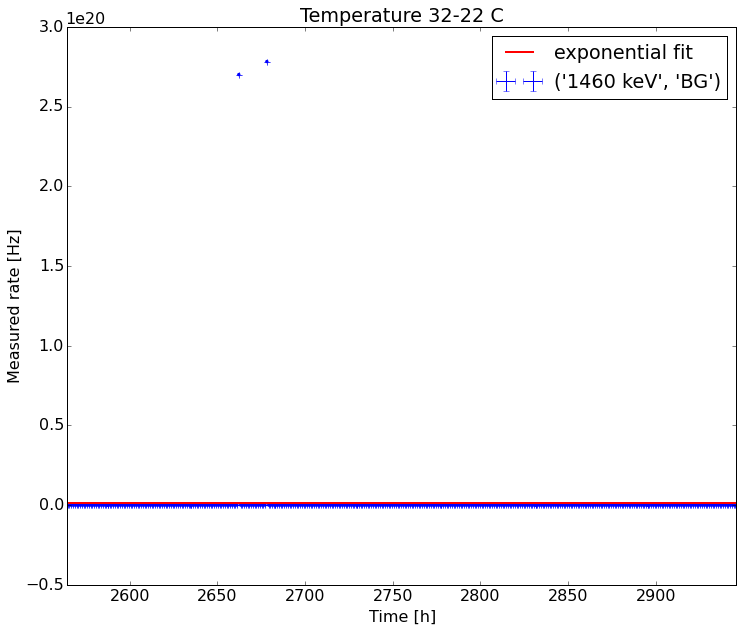

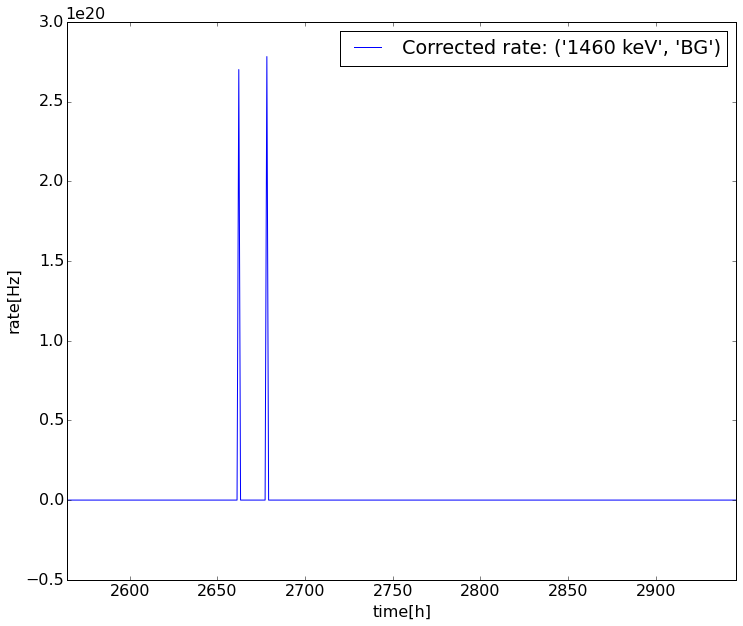

For ('1460 keV', 'BG'):
Half life time : 1251000000.0 yr
A0 : 0.541489039324 +- 0.302353749313 Bq


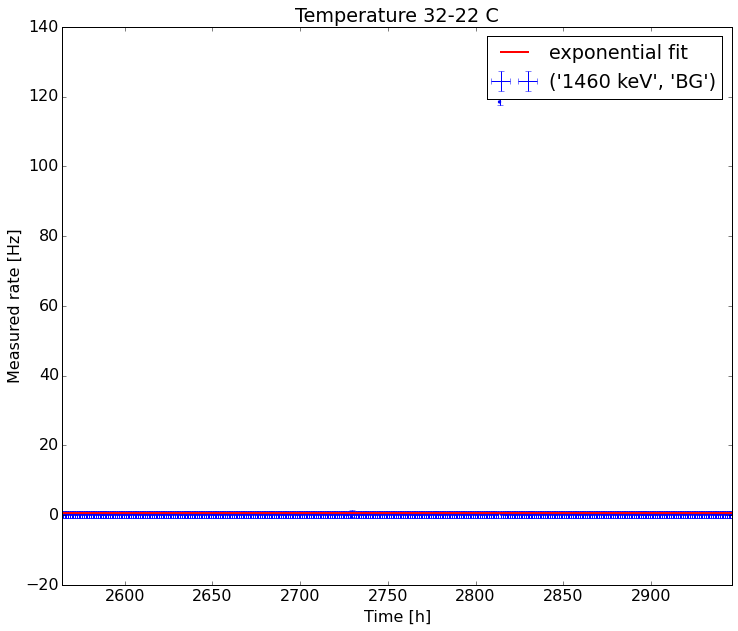

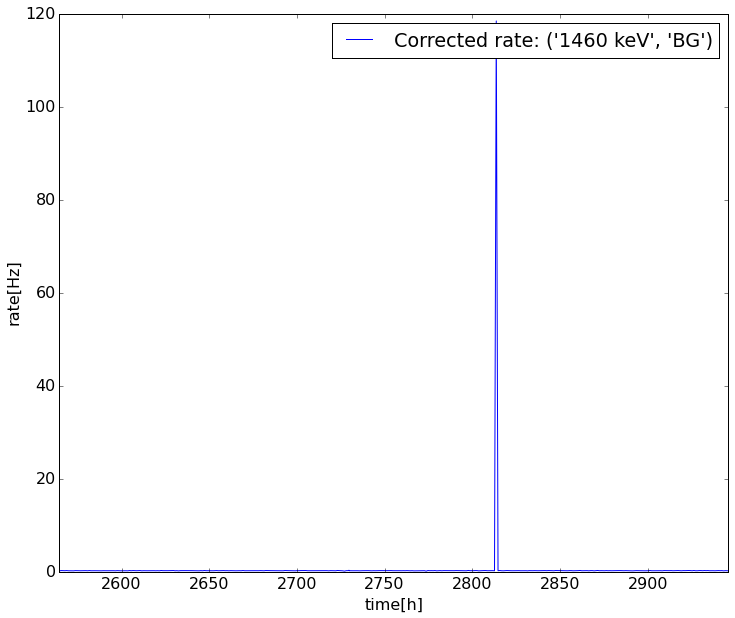

For ('511 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 200.568516625 +- 0.0141544337493 Bq


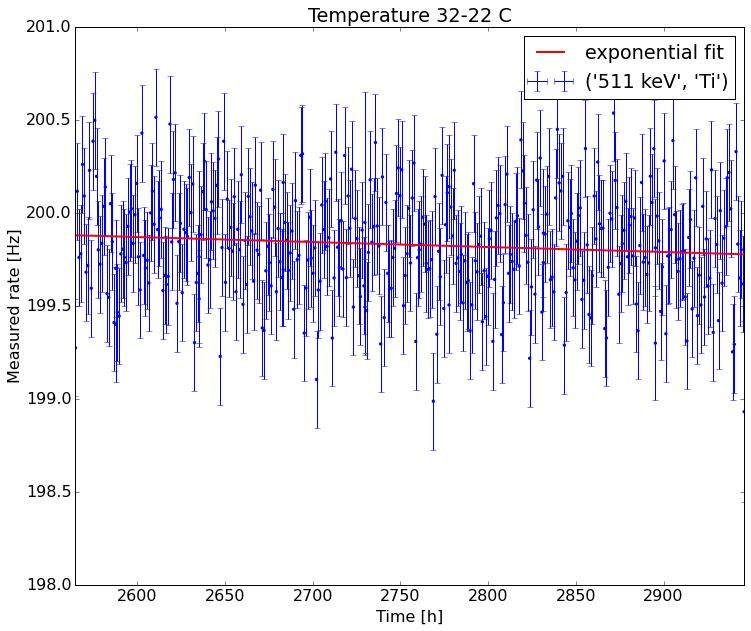

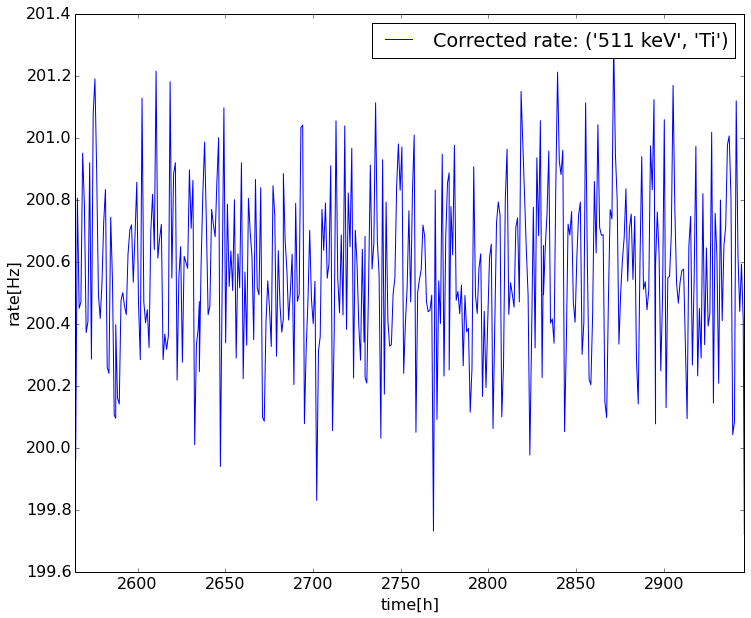

Half life time : 58.9 yr
A0 : 200.568516625 +- 0.0141544337493 Bq


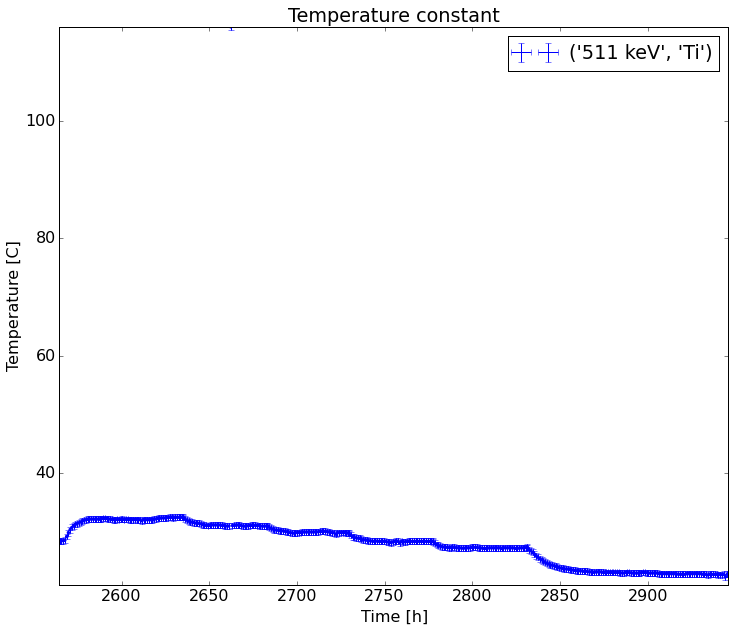

For ('1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 29.6627782446 +- 0.00658271144181 Bq


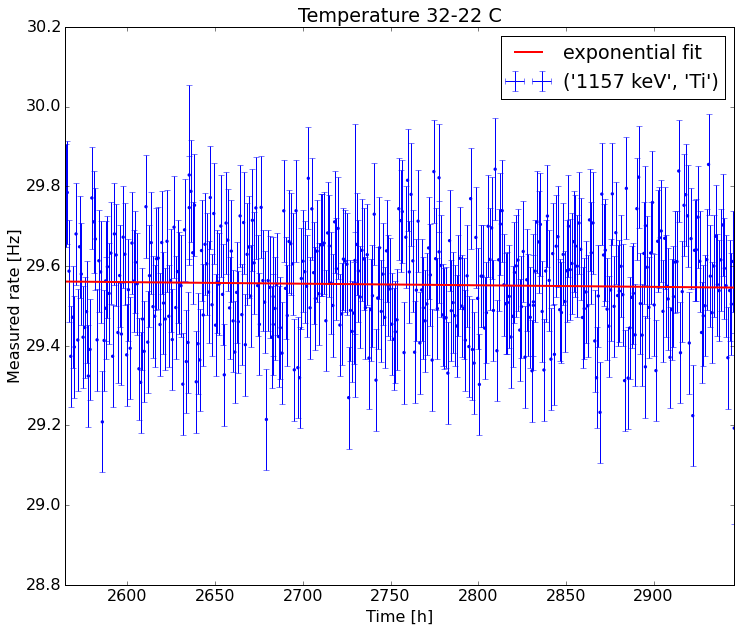

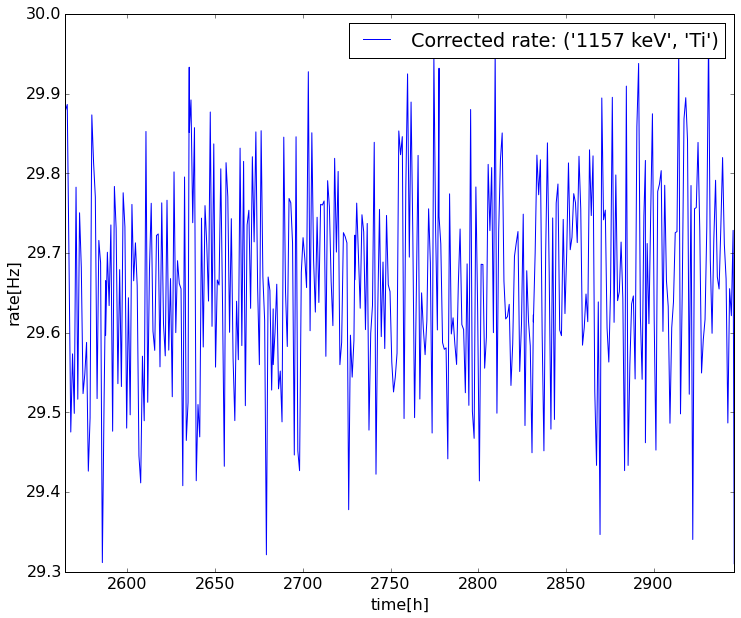

For ('511.+1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 21.6871732555 +- 0.00438981807171 Bq


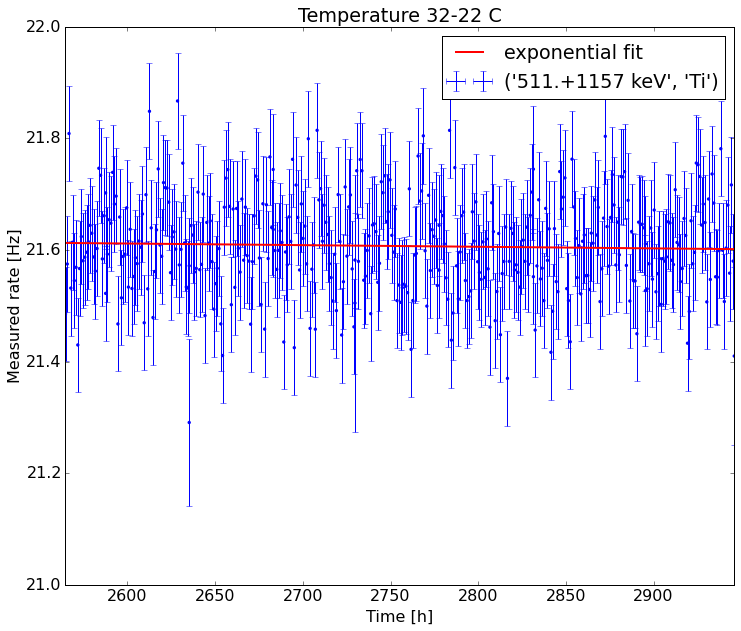

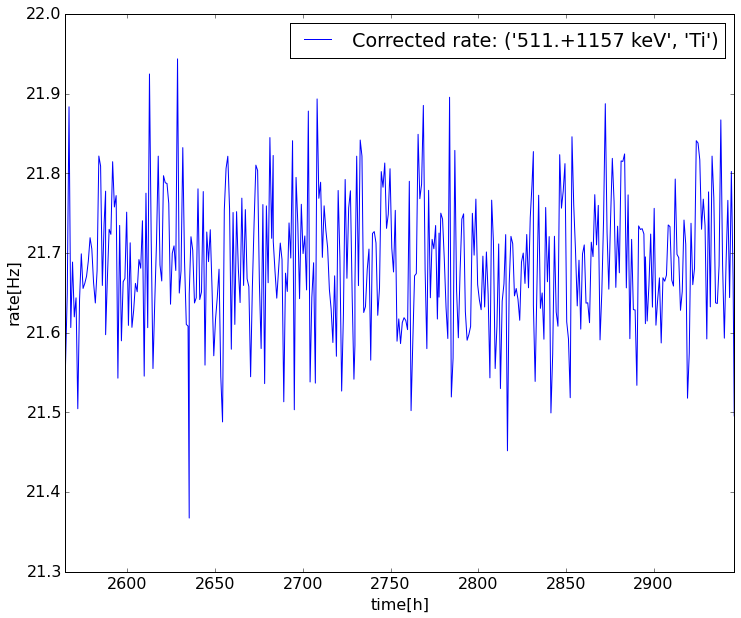

For ('511 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 200.926456943 +- 0.0132267788664 Bq


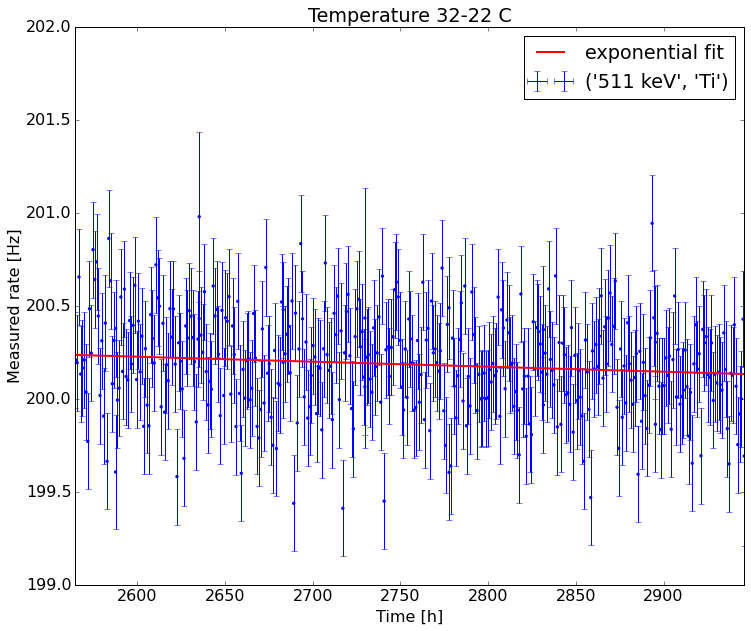

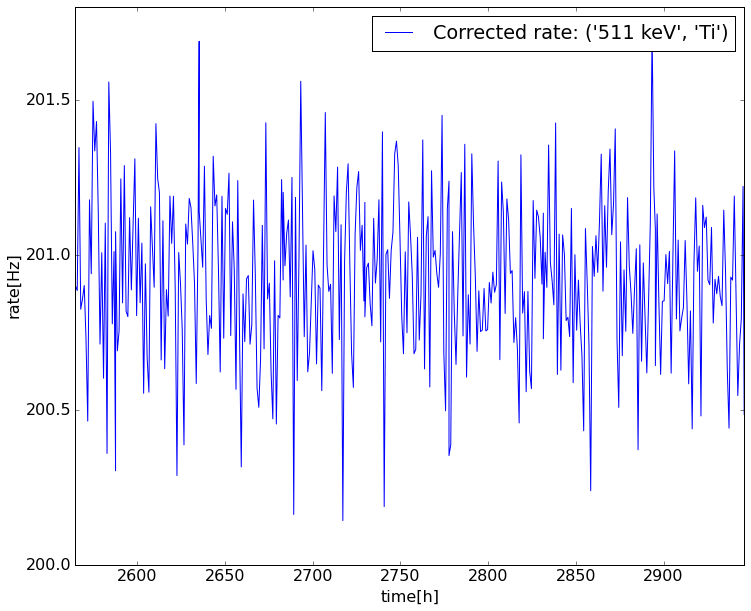

For ('1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 30.6921138507 +- 0.00647708344 Bq


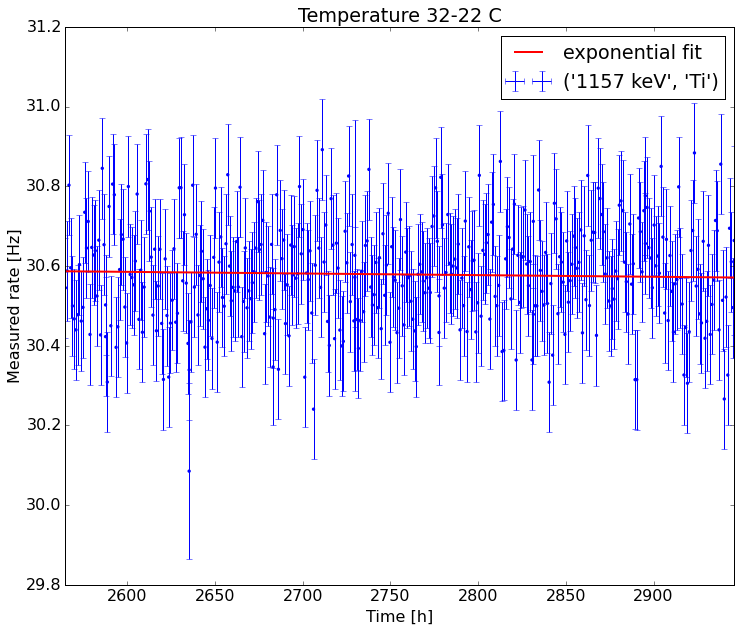

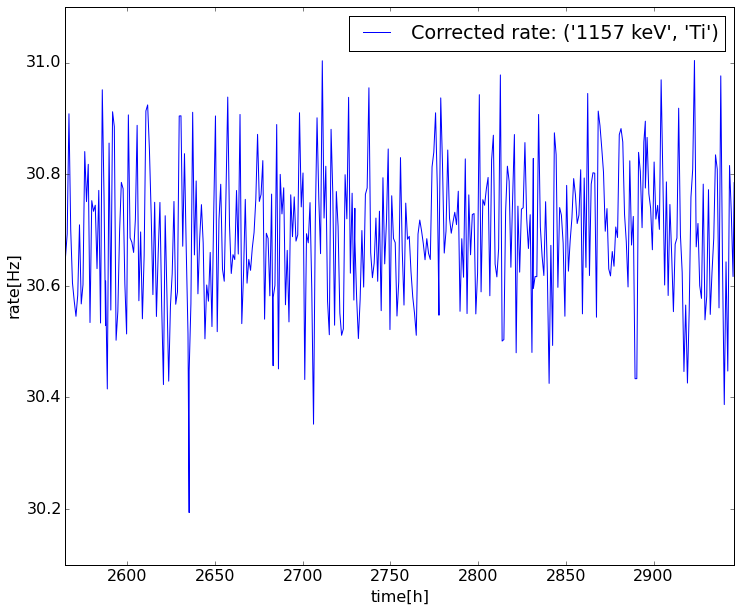

For ('511.+1157 keV', 'Ti'):
Half life time : 58.9 yr
A0 : 22.906852651 +- 0.00441925966625 Bq


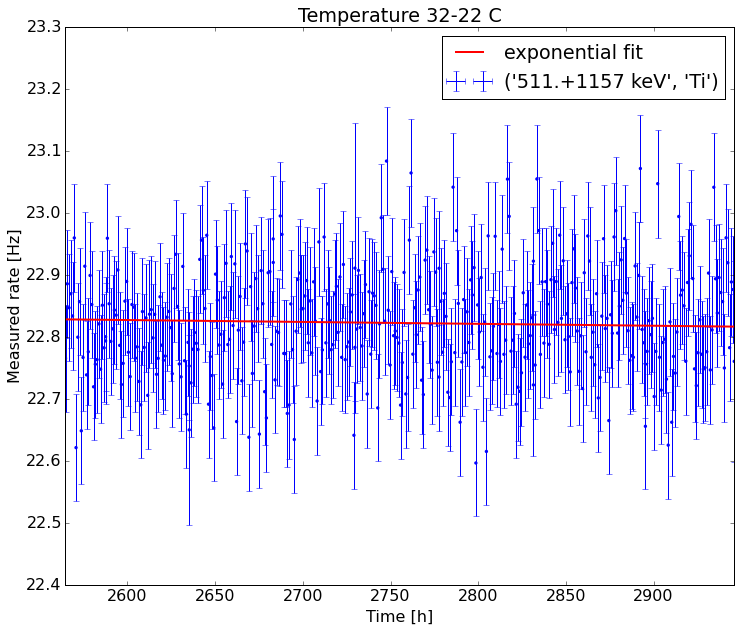

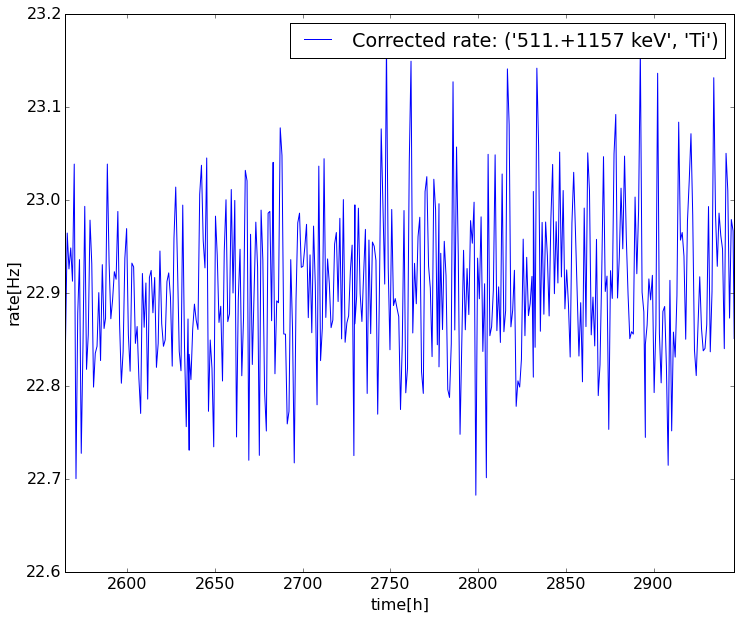

For ('1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 34.8820980244 +- 0.00625054710042 Bq


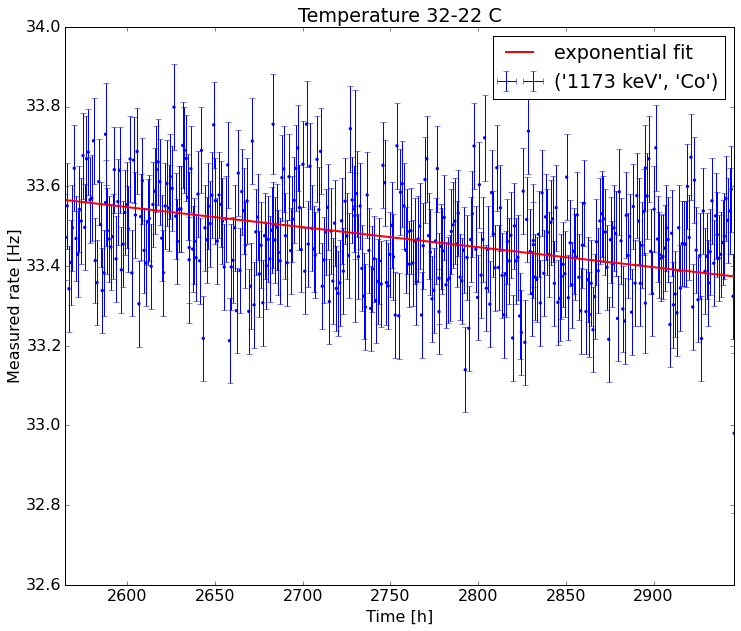

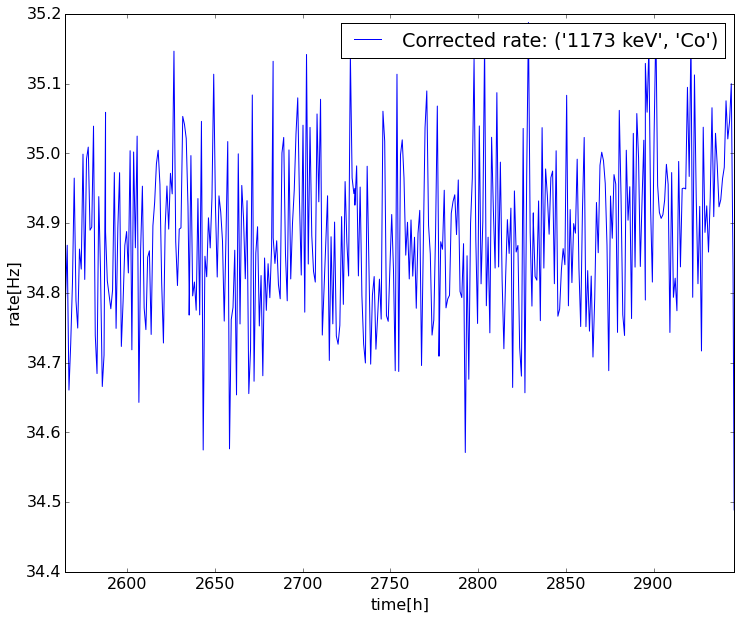

For ('1332 keV', 'Co'):
Half life time : 5.27 yr
A0 : 30.8234720949 +- 0.00544864907264 Bq


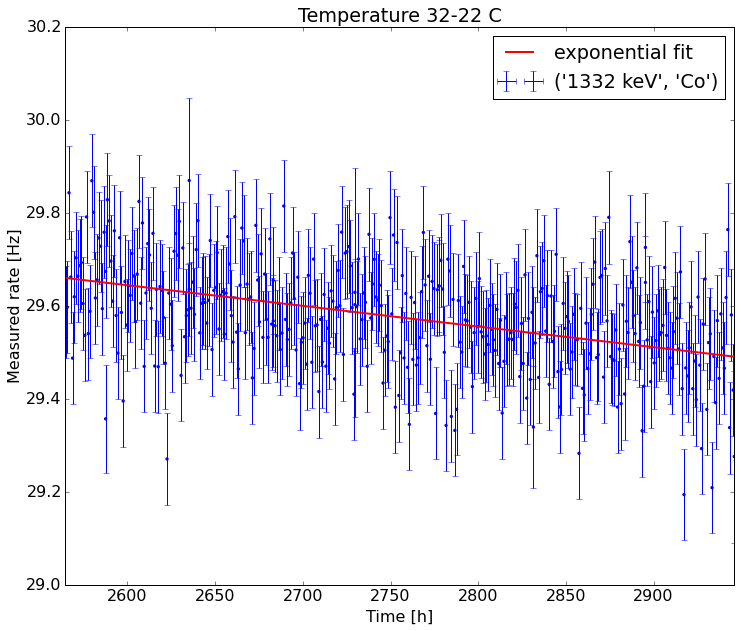

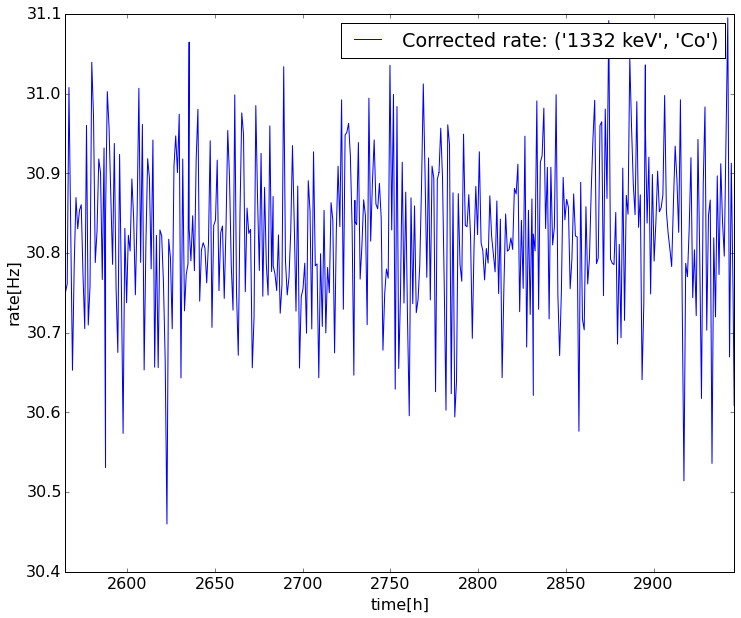

For ('1332 + 1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 3.69929365042 +- 0.00175683146492 Bq


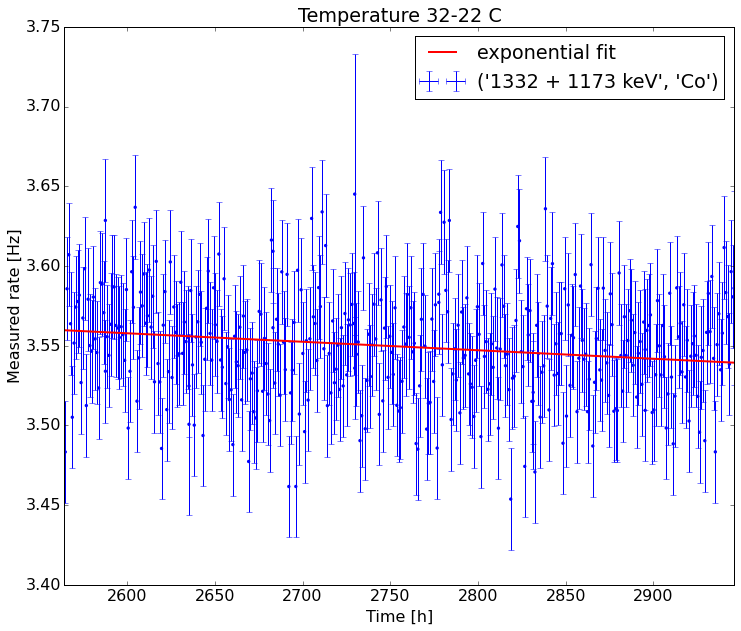

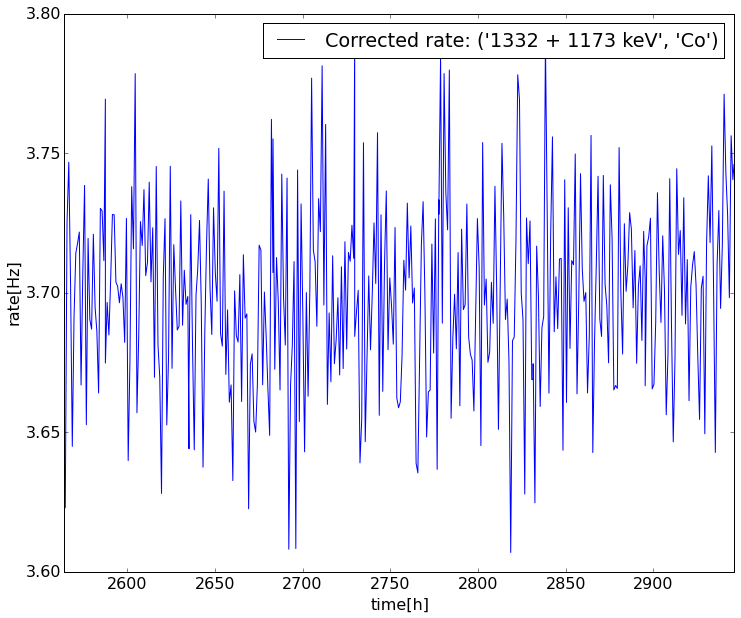

For ('1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 33.83178914 +- 0.00529356253423 Bq


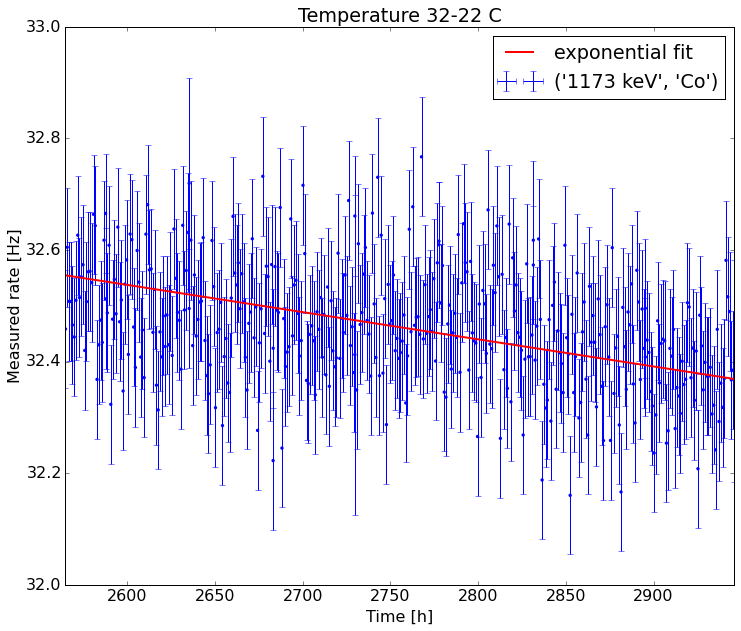

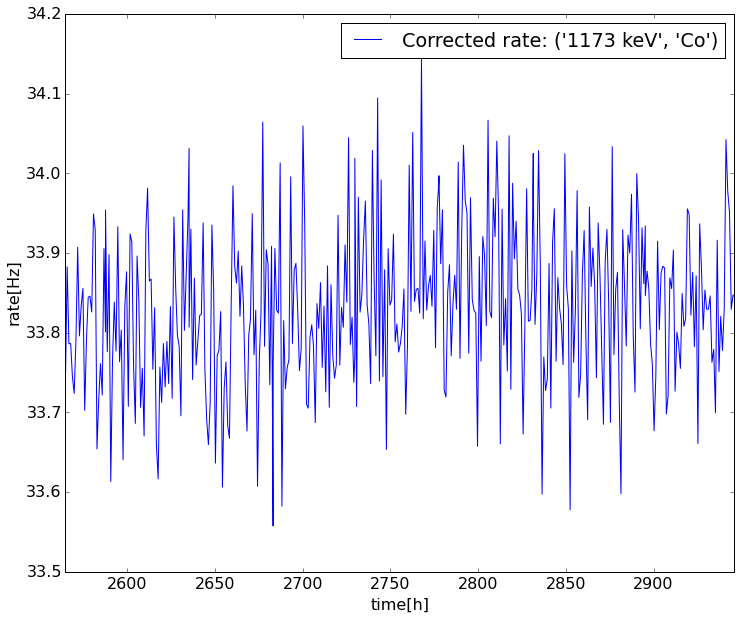

For ('1332 keV', 'Co'):
Half life time : 5.27 yr
A0 : 29.9962674827 +- 0.00562007045112 Bq


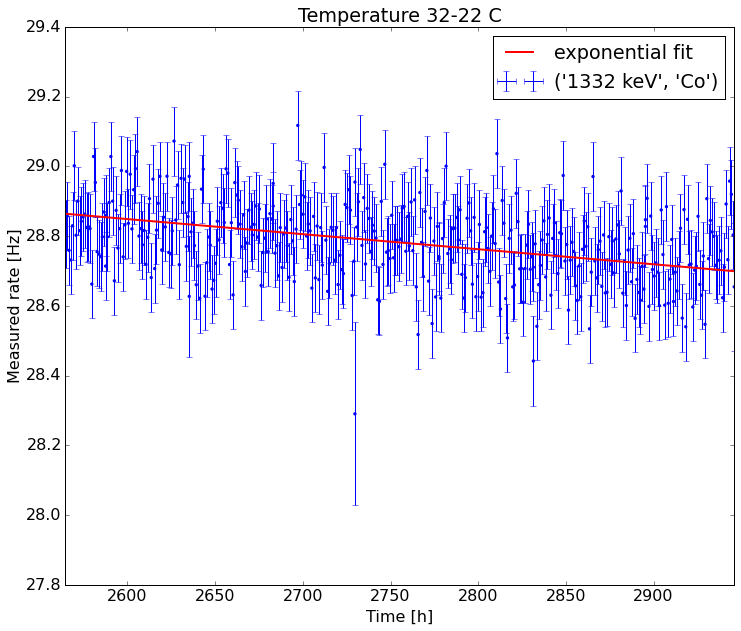

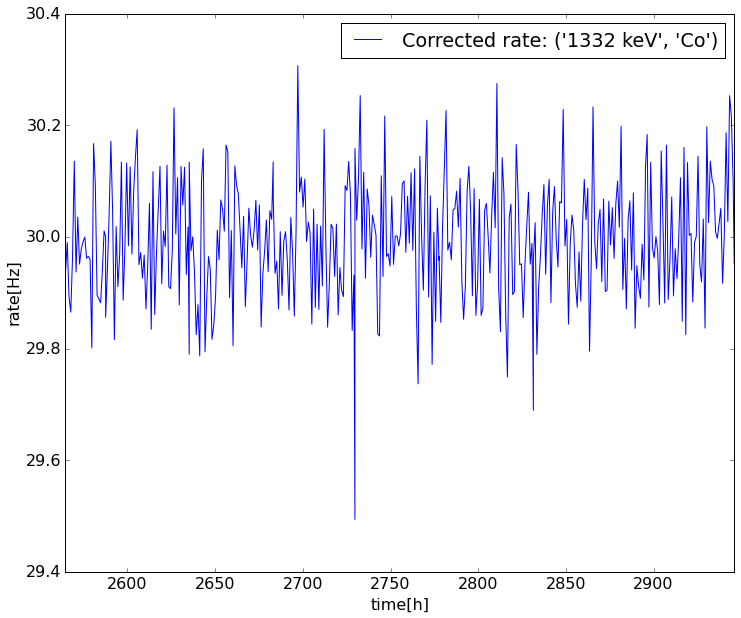

For ('1332 + 1173 keV', 'Co'):
Half life time : 5.27 yr
A0 : 3.39612293342 +- 0.0016691340153 Bq


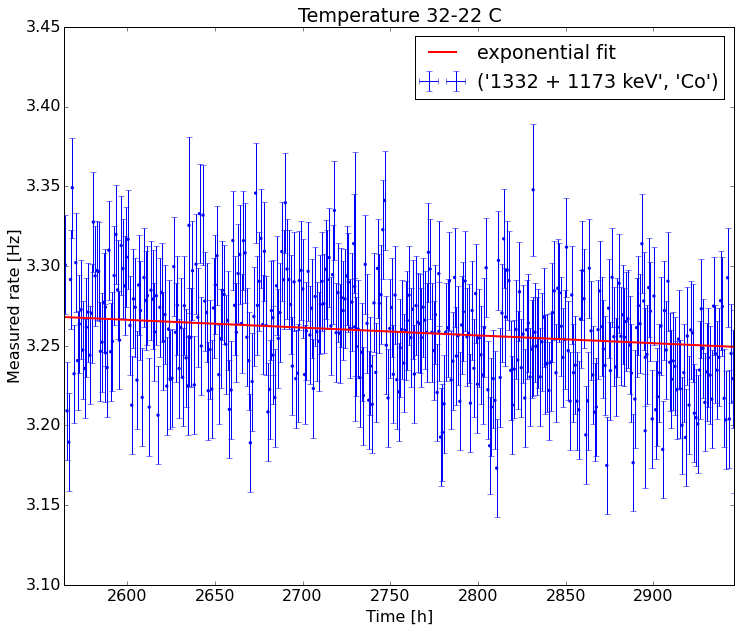

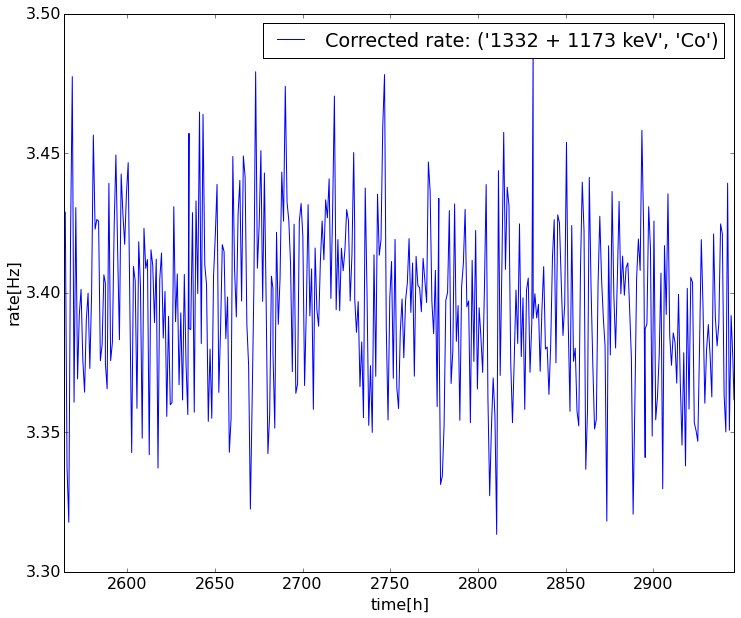

For ('662 keV', 'Cs'):
Half life time : 30.05 yr
A0 : 84.2421227787 +- 0.00831841965299 Bq


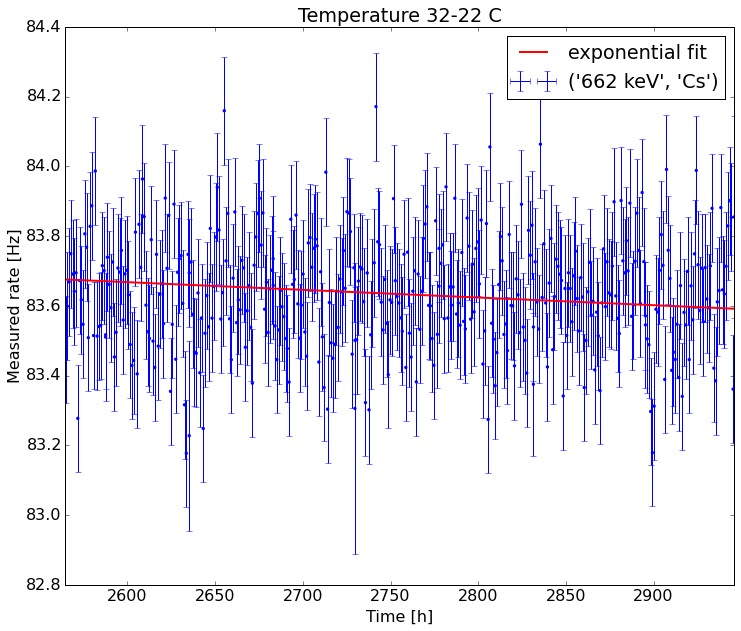

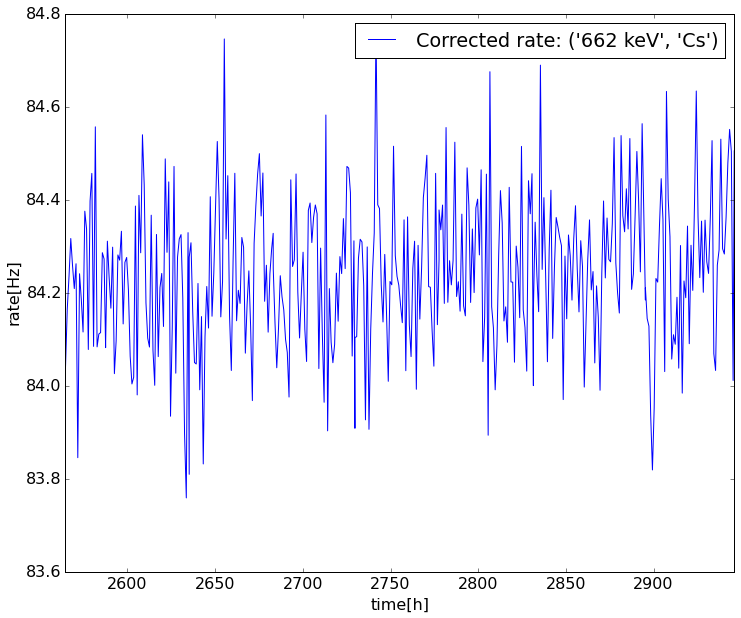

For ('662 keV', 'Cs'):
Half life time : 30.05 yr
A0 : 112.320255889 +- 0.00925598455609 Bq


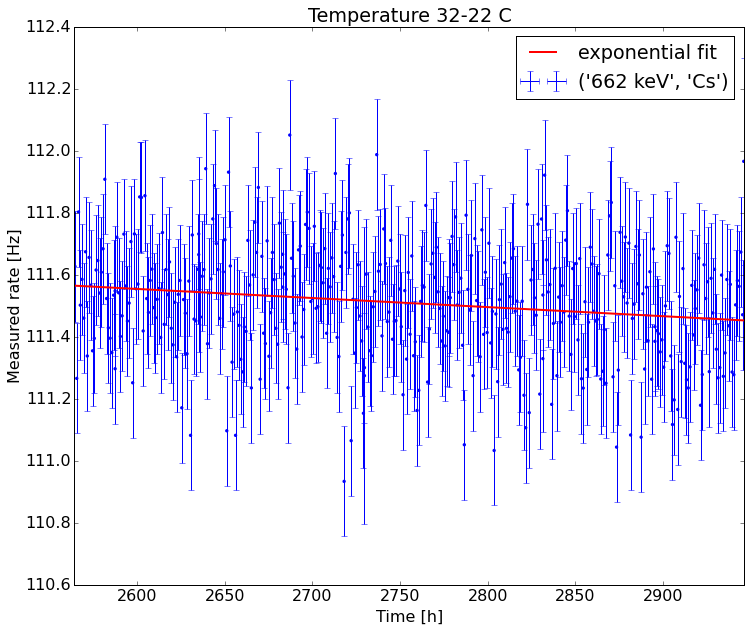

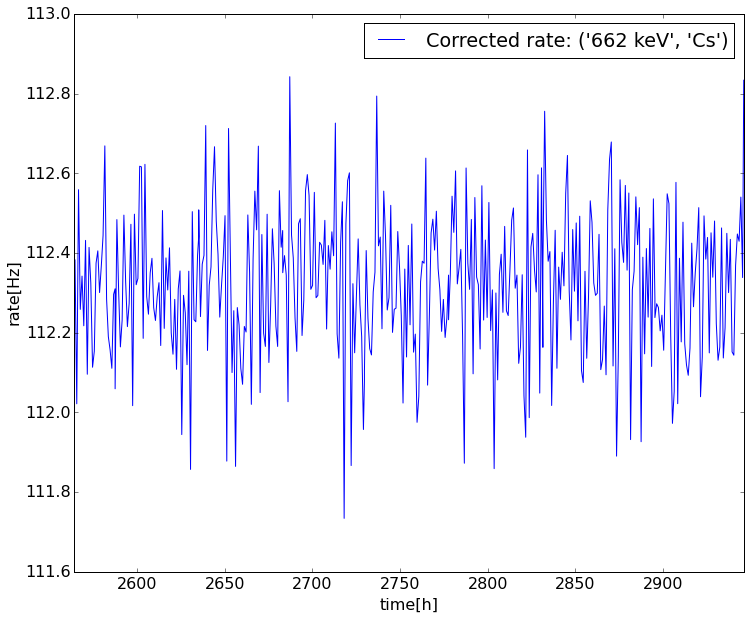

In [6]:
# Plot temperature vs time: Get data, organize and average data per degree and determine and caculate errors
data = recursive_defaultdict()
degrees = np.linspace(22,33,10)
lists = recursive_defaultdict()

for (channel_i, peak_i), peakd in datas.groupby(['channel','peak']):
    rate = peakd['rate']
    drate = peakd['drate'] # error on rate according to dataset (thus from AP's code)
    temp = peakd['temp']
    pres = peakd['pres']
    bx   = peakd['bx']
    by   = peakd['by']
    bz   = peakd['bz']
    btot = peakd['btot']
    humid= peakd['humid']
    time = data_time_hours

    # for every channel and peak combination fill lists with data
    lists['rate']['value'] = np.array(rate)
    lists['temp']['value'] = np.array(temp)
    lists['time']['value'] = np.array(time)
    lists['pres']['value'] = np.array(pres)
    lists['btot']['value'] = np.array(btot)
    lists['humid']['value'] = np.array(humid)
    
    # add errors    
    # HACK: rate should not have negative numbers!
    # Each datapoint is 1 hour of data
#     lists['rate']['error'] = ((np.abs(np.array(rate))*60*60)**(0.5))/(60*60)
    lists['rate']['error'] = np.array(drate)
    lists['temp']['error'] = [0.5]*len(temp)
    lists['time']['error'] = [0.00000000001*60*60]*len(time) # just very, very small
    # !! Don't know the errors in the var below jet, 0.0001 is a random, small choice
    lists['pres']['error'] = [0.0001]*len(pres)
    lists['btot']['error'] = [0.0001]*len(btot)
    lists['humid']['error'] = [0.0001]*len(humid)
    
    # make lists within loop over variables with very scary default dicts
    for var in lists: 
        for degree in degrees:
            data[channel_i][peak_i][var][degree]['value'] = []
            data[channel_i][peak_i][var][degree]['error'] = []
        
    # Define fit-function. Use half life time from literature
    if channel_i == 0 or channel_i == 1:
        half_life_time = (1.251*10**9)*365.25*24*60*60.
    elif channel_i == 2 or channel_i == 3:
        half_life_time = (58.9)*365.25*24*60*60.
    elif channel_i == 4 or channel_i == 5:
        half_life_time = (5.27)*365.25*24*60*60.
    elif channel_i == 6 or channel_i == 7:
        half_life_time = (30.05)*365.25*24*60*60.
    
    print("For %s:" % (fit_values[channel_i][peak_i],))
    # Determine first guess for A0(measured) and half-life
    guessA0 = max(lists['rate']['value']) #max value is presumably the activity at t=0 (since it only decreases)
    guessExp = (guessA0)
    
    # Now fit exponent to data
    found_fit_signal = fit_signal(lists['rate']['value'], guessExp, time)
    found_residual = residual(time, lists['rate']['value'], found_fit_signal[0])
    
    # plot rate vs time    
    plt.xlabel('Time [h]')
    plt.ylabel('Measured rate [Hz]')
    plt.errorbar(time, lists['rate']['value'], xerr=lists['time']['error'], yerr=lists['rate']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
    plt.scatter(time, lists['rate']['value'], marker='.', edgecolors='none', s=45)
    plt.plot(time, found_fit_signal[0], 'r', linewidth=2.0, label="exponential fit")
    plt.title('Temperature 32-22 C')
    plt.xlim(starting_time,max(time))   
    plt.legend()
    if channel_i == 2 and peak_i == 0:
        plt.savefig('rate_vs_time_fitEXP_Ti_511kev_T3222_toCombine.png', format='png', dpi=300)
        plt.savefig('rate_vs_time_fitEXP_Ti_511kev_T3222_toCombine.pdf', format='pdf', dpi=300)
    plt.show()
   
    # Calculate corrected rate:
    corr_rate = found_residual+found_fit_signal[1]
    plt.plot(time, corr_rate, label='Corrected rate: %s' %(fit_values[channel_i][peak_i],))
    plt.xlim(starting_time, max(time))
    plt.xlabel('time[h]')
    plt.ylabel('rate[Hz]')
    plt.legend()
#     if channel_i == 2 and peak_i == 0:
#         plt.savefig('residual_Ti_511keV.png', format='png', dpi=300)
    plt.show()
    
    # For now: save only the arrays for the Ti-44 pk0 measurement.
    # Because we only need one to show the plot. 
    if channel_i == 2 and peak_i == 0:
        found_fit_signalTipk0 = fit_signal(lists['rate']['value'], guessExp, time)
        np.savetxt('ti44pk0_rate_T3222_toCombine', (lists['rate']['value']))
        np.savetxt('ti44pk0_error_rate_T3222_toCombine', (lists['rate']['error']))
        np.savetxt('ti44pk0_residual_T3222_toCombine', (found_residual))
        np.savetxt('ti44pk0_foundFitA0_and_Error_andStartingTime_3222_toCombine', (found_fit_signalTipk0[1], found_fit_signalTipk0[2], starting_time))
        np.savetxt('ti44pk0_corrected_rate_3222_toCombine', (found_residual+found_fit_signalTipk0[1]))
        np.savetxt('ti44pk0_time_T3222_toCombine', (time))
        
        np.savetxt('ti44pk0_pres_T3222_toCombine', (pres))
        np.savetxt('ti44pk0_temp_T3222_toCombine', (temp))
        np.savetxt('ti44pk0_humid_T3222_toCombine', (humid))
        
        # Slow control parameters temperature, pressure and humidity plotted.
        # Just for fun. To see whether strange things happen.
        # Time vs temp
        plt.xlabel('Time [h]')
        plt.ylabel('Temperature [C]')
        plt.errorbar(time, lists['temp']['value'], xerr=lists['time']['error'], yerr=lists['temp']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
        plt.scatter(time, lists['temp']['value'], marker='.', edgecolors='none', s=45)
        plt.title('Temperature constant')
        plt.xlim(starting_time,max(time))   
        plt.ylim(21,max(lists['temp']['value']))
        plt.legend()
        plt.show()
        
#         # Time vs pres
#         plt.xlabel('Time [h]')
#         plt.ylabel('Pressure []')
#         plt.errorbar(time, lists['pres']['value'], xerr=lists['time']['error'], yerr=lists['pres']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
#         plt.scatter(time, lists['pres']['value'], marker='.', edgecolors='none', s=45)
#         plt.title('Temperature constant')
#         plt.xlim(0,max(time))   
#         plt.ylim(97500.,104000)
#         plt.legend()
#         plt.show()
        
#         # Time vs humid
#         plt.xlabel('Time [h]')
#         plt.ylabel('Humidity []')
#         plt.errorbar(time, lists['humid']['value'], xerr=lists['time']['error'], yerr=lists['humid']['error'],fmt=None, marker=None, label = fit_values[channel_i][peak_i])
#         plt.scatter(time, lists['humid']['value'], marker='.', edgecolors='none', s=45)
#         plt.title('Temperature constant')
#         plt.xlim(0,max(time))   
#         plt.ylim(-20.,-10)
#         plt.legend()
#         plt.show()    